In [22]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
#from sklearn_extra.cluster import KMedoids
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
import prince
# add fcluster
from scipy.cluster.hierarchy import fcluster
# metrics.cluster.contingency_matrix
from sklearn import metrics
# Numpy
import numpy as np
from scipy.special import comb


#import gower


In [4]:
df = pd.read_csv('./in-vehicle-coupon-recommendation.csv')

In [5]:
df = df.drop(columns=['car'])
df = df.drop(columns=['toCoupon_GEQ5min'])
df = df.drop(columns=['direction_opp'])
df = df.drop_duplicates()

In [6]:
for column in df.columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [7]:
def value_mapping(df: pd.DataFrame):
    frequency_map = {'never': 0,'less1': 1,'1~3': 2,'4~8': 3,'gt8': 4}
    age_map = {'below21': 0,'21': 1,'26': 2,'31': 3,'36': 4,'41': 5,'46': 6,'50plus': 7}
    income_map = {'Less than $12500': 0,'$12500 - $24999': 1,'$25000 - $37499': 2,'$37500 - $49999': 3,
    '$50000 - $62499': 4,'$62500 - $74999': 5,'$75000 - $87499': 6,'$87500 - $99999': 7,'$100000 or More': 8}
    temperature_map = {30: 0,55: 1,80: 2}

    # CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50, Bar
    df['CoffeeHouse'] = df['CoffeeHouse'].map(frequency_map)
    df['CarryAway'] = df['CarryAway'].map(frequency_map)
    df['RestaurantLessThan20'] = df['RestaurantLessThan20'].map(frequency_map)
    df['Restaurant20To50'] = df['Restaurant20To50'].map(frequency_map)
    df['Bar'] = df['Bar'].map(frequency_map)

    #age
    df['age'] = df['age'].map(age_map)

    #income 
    df['income'] = df['income'].map(income_map)

    #temperature
    df['temperature'] = df['temperature'].map(temperature_map)

    return df

In [8]:
df = value_mapping(df)

In [9]:
df['Y']

0        1
1        0
2        1
3        0
4        0
        ..
12679    1
12680    1
12681    0
12682    0
12683    0
Name: Y, Length: 12610, dtype: int64

In [10]:
from sklearn.preprocessing import OrdinalEncoder

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Columns for ordinal encoding
ordinal_cols = ['destination', 'weather', 'time', 'expiration', 'maritalStatus', 'education']

# Define the specific ordering for ordinal columns
ordinal_ordering = {
    'destination': ['No Urgent Place', 'Home', 'Work'],
    'weather': ['Sunny', 'Rainy', 'Snowy'],
    'time': ['7AM', '10AM', '2PM', '6PM', '10PM'],
    'expiration': ['2h', '1d'],
    'maritalStatus': ['Single', 'Unmarried partner', 'Married partner', 'Divorced', 'Widowed'],
    'education': ['Some High School', 'High School Graduate', 'Some college - no degree', 
                  'Associates degree', 'Bachelors degree', 'Graduate degree (Masters or Doctorate)']
}

# Ordinal encoding
ordinal_encoder = OrdinalEncoder(categories=[ordinal_ordering[col] for col in ordinal_cols])
df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])

# Identify columns to be one-hot encoded (excluding already binary or ordinal encoded columns)
columns_to_encode = df.columns.drop(ordinal_cols + ['temperature', 'age', 'has_children', 'income',
                                                    'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20',
                                                    'Restaurant20To50', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 
                                                    'direction_same', 'Y'])  # Add any other columns to exclude

# One-hot encoding for the non-binary categorical columns
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=False, dtype=int)

# df now contains your processed data


In [11]:
X = df.drop("Y", axis=1)
y = df["Y"]

In [12]:
mca = prince.MCA(n_components=2, random_state=42)
X_mca = mca.fit_transform(X)

In [13]:
for column in X.columns:
    print(f"{column}: {X[column].unique()}")

destination: [0. 1. 2.]
weather: [0. 1. 2.]
temperature: [1 2 0]
time: [2. 1. 3. 0. 4.]
expiration: [1. 0.]
age: [1 6 2 3 5 7 4 0]
maritalStatus: [1. 0. 2. 3. 4.]
has_children: [1 0]
education: [2. 4. 3. 1. 5. 0.]
income: [3 5 1 6 4 2 8 7 0]
Bar: [0 1 2 4 3]
CoffeeHouse: [0 1 3 2 4]
CarryAway: [2 3 4 1 0]
RestaurantLessThan20: [3 2 1 4 0]
Restaurant20To50: [2 1 0 4 3]
toCoupon_GEQ15min: [0 1]
toCoupon_GEQ25min: [0 1]
direction_same: [0 1]
passanger_Alone: [1 0]
passanger_Friend(s): [0 1]
passanger_Kid(s): [0 1]
passanger_Partner: [0 1]
coupon_Bar: [0 1]
coupon_Carry out & Take away: [0 1]
coupon_Coffee House: [0 1]
coupon_Restaurant(20-50): [0 1]
coupon_Restaurant(<20): [1 0]
gender_Female: [1 0]
gender_Male: [0 1]
occupation_Architecture & Engineering: [0 1]
occupation_Arts Design Entertainment Sports & Media: [0 1]
occupation_Building & Grounds Cleaning & Maintenance: [0 1]
occupation_Business & Financial: [0 1]
occupation_Community & Social Services: [0 1]
occupation_Computer & Math

# Clustering 

In [26]:
# Calculate purity
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

# Indice Rand
# import comb


def rand_index_score(clusters, classes):
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

# F-measure
def f_measure(y_true, y_pred):
    # Compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)

    # Compute precision and recall
    row_sums = contingency_matrix.sum(axis=1)
    col_sums = contingency_matrix.sum(axis=0)

    # Ensure proper broadcasting by reshaping row_sums
    precision = np.max(contingency_matrix / col_sums, axis=0).mean()
    recall = np.max(contingency_matrix / row_sums[:, np.newaxis], axis=1).mean()

    # Compute f measure
    return 2 * precision * recall / (precision + recall)


### Hierarchical Clustering

Metrics for Single Linkage with 2 clusters:
Contingency Matrix:
[[   8 5445]
 [  12 7145]]
Number of Clusters: 2
Samples per Cluster: [   20 12590]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5090057081315167
F-Measure: 0.7367524379809234



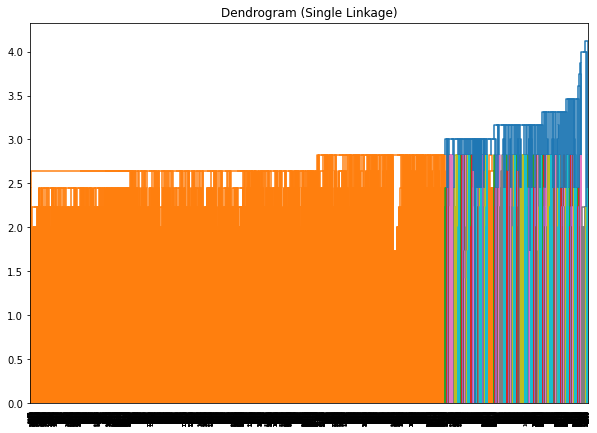

Metrics for Single Linkage with 3 clusters:
Contingency Matrix:
[[   8 5445]
 [  12 7145]]
Number of Clusters: 2
Samples per Cluster: [   20 12590]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5090057081315167
F-Measure: 0.7367524379809234



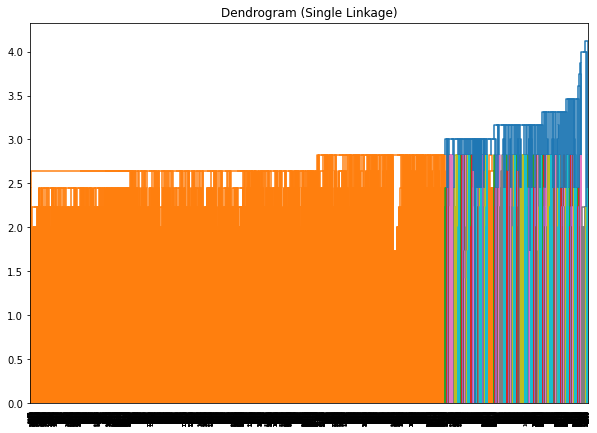

Metrics for Single Linkage with 4 clusters:
Contingency Matrix:
[[   8    7   45 5393]
 [  12   15   64 7066]]
Number of Clusters: 4
Samples per Cluster: [   20    22   109 12459]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5084356056739553
F-Measure: 0.7535907660672423



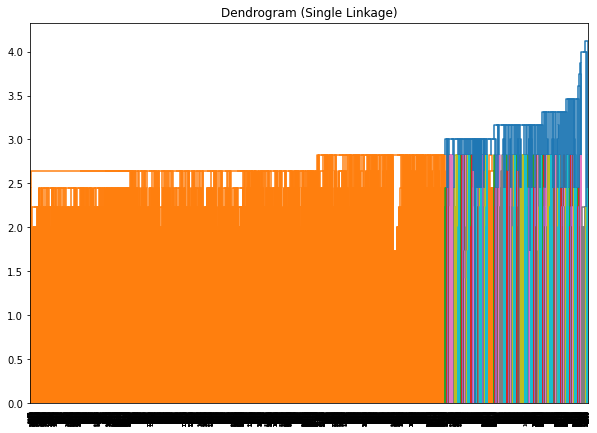

Metrics for Complete Linkage with 2 clusters:
Contingency Matrix:
[[2986 2467]
 [4236 2921]]
Number of Clusters: 2
Samples per Cluster: [7222 5388]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5019528553204793
F-Measure: 0.567019272157278



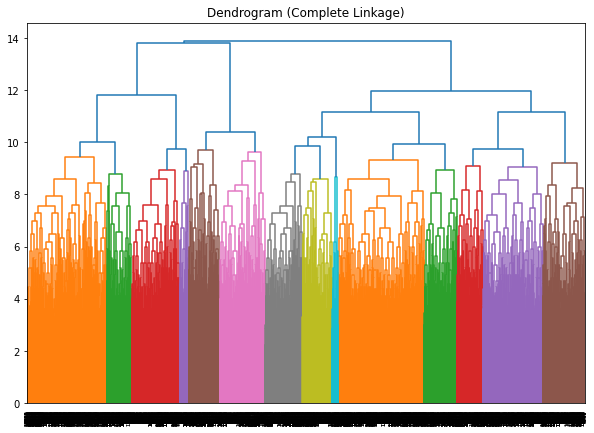

Metrics for Complete Linkage with 3 clusters:
Contingency Matrix:
[[2986  747 1720]
 [4236  985 1936]]
Number of Clusters: 3
Samples per Cluster: [7222 1732 3656]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5013062117369056
F-Measure: 0.5656329687473837



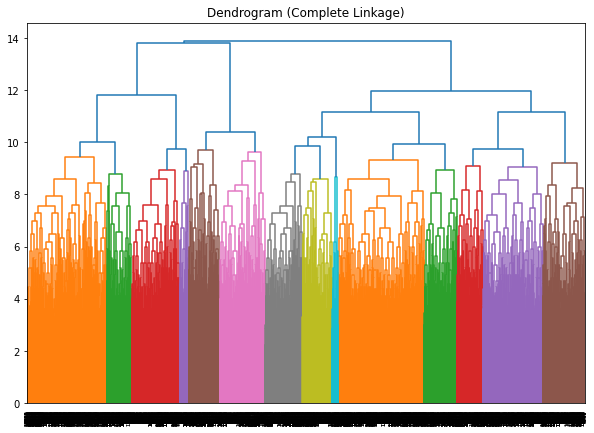

Metrics for Complete Linkage with 4 clusters:
Contingency Matrix:
[[1233 1753  747 1720]
 [1653 2583  985 1936]]
Number of Clusters: 4
Samples per Cluster: [2886 4336 1732 3656]
Purity Score: 0.5675654242664552
Rand Index Score: 0.4969212920116914
F-Measure: 0.42593234952553266



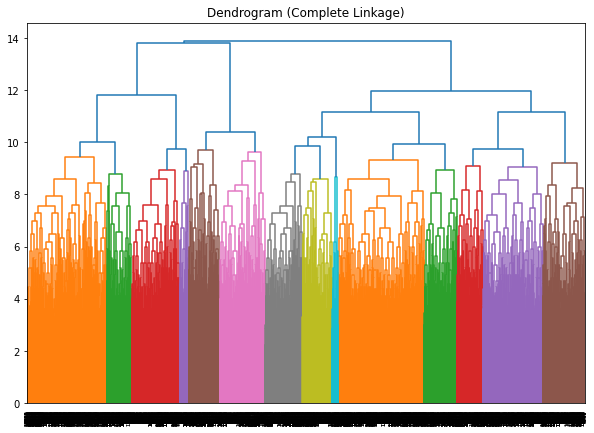

Metrics for Average Linkage with 2 clusters:
Contingency Matrix:
[[  52 5401]
 [  79 7078]]
Number of Clusters: 2
Samples per Cluster: [  131 12479]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5085216940004021
F-Measure: 0.7354466362521461



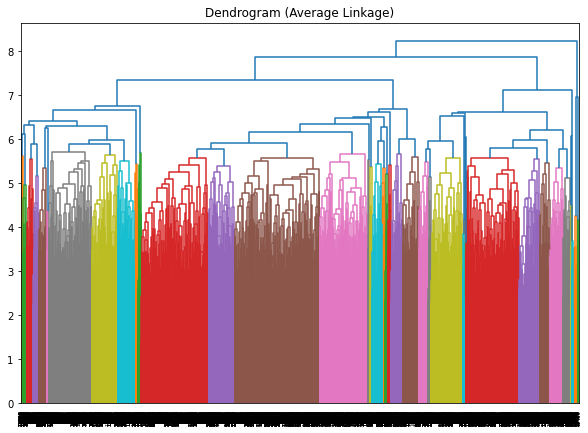

Metrics for Average Linkage with 3 clusters:
Contingency Matrix:
[[  52 1586 3815]
 [  79 1891 5187]]
Number of Clusters: 3
Samples per Cluster: [ 131 3477 9002]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5032580293182073
F-Measure: 0.6358958663107773



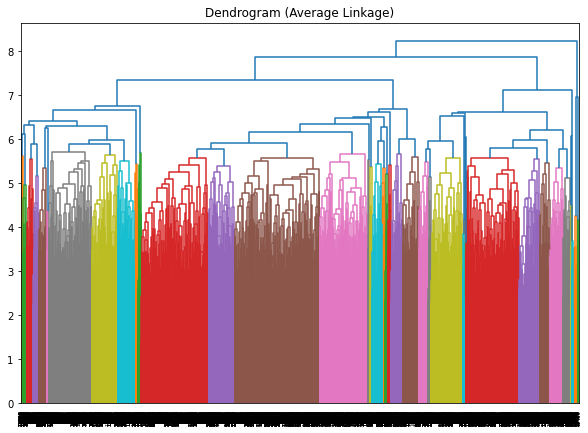

Metrics for Average Linkage with 4 clusters:
Contingency Matrix:
[[  52 1586 2603 1212]
 [  79 1891 3669 1518]]
Number of Clusters: 4
Samples per Cluster: [ 131 3477 6272 2730]
Purity Score: 0.5675654242664552
Rand Index Score: 0.49915492181767374
F-Measure: 0.5307140708386033



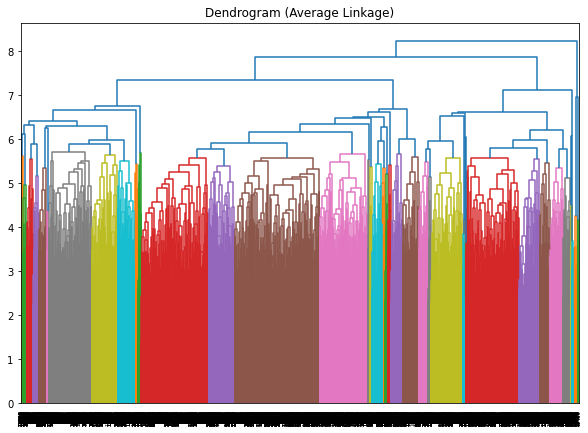

Metrics for Ward Linkage with 2 clusters:
Contingency Matrix:
[[1630 3823]
 [1977 5180]]
Number of Clusters: 2
Samples per Cluster: [3607 9003]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5031682177093776
F-Measure: 0.6281673634399656



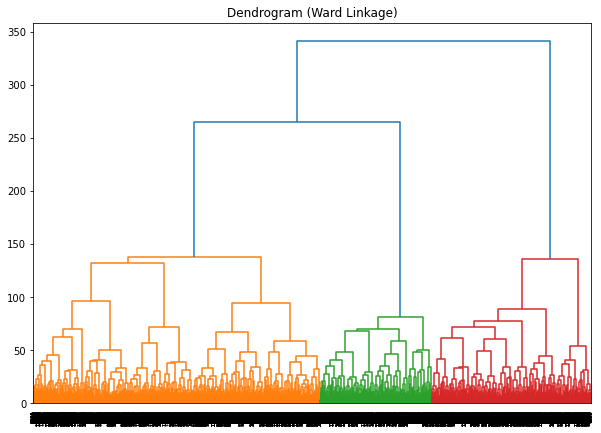

Metrics for Ward Linkage with 3 clusters:
Contingency Matrix:
[[1630 1150 2673]
 [1977 1365 3815]]
Number of Clusters: 3
Samples per Cluster: [3607 2515 6488]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5000797801301123
F-Measure: 0.5345417740084304



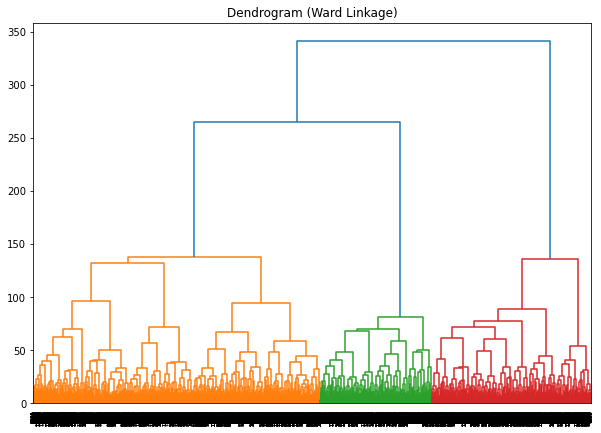

Metrics for Ward Linkage with 4 clusters:
Contingency Matrix:
[[1630 1150 1111 1562]
 [1977 1365 1784 2031]]
Number of Clusters: 4
Samples per Cluster: [3607 2515 2895 3593]
Purity Score: 0.5675654242664552
Rand Index Score: 0.4961094906656619
F-Measure: 0.38516227053594765



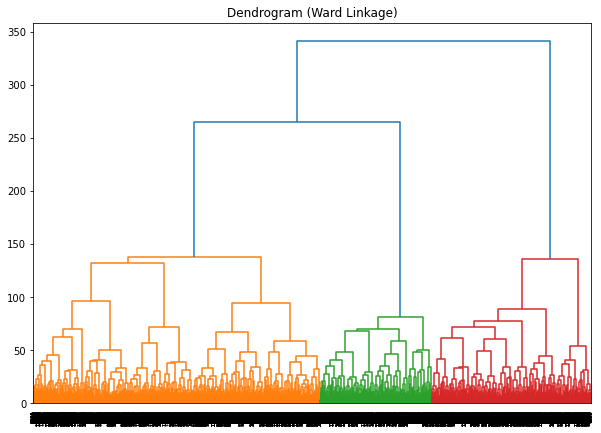

Metrics for Centroid Linkage with 2 clusters:
Contingency Matrix:
[[   3 5450]
 [  15 7142]]
Number of Clusters: 2
Samples per Cluster: [   18 12592]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5088358459514556
F-Measure: 0.8232597406324964



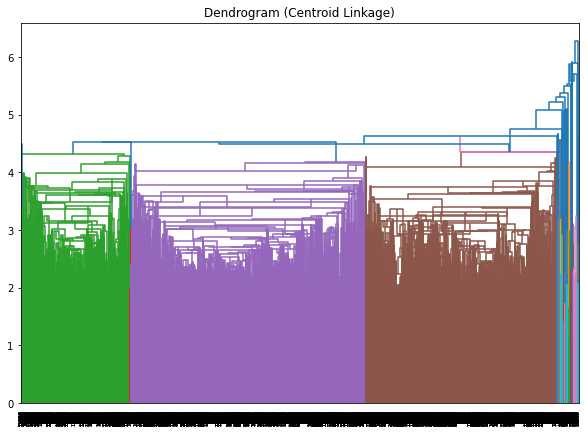

Metrics for Centroid Linkage with 3 clusters:
Contingency Matrix:
[[   3 5450]
 [  15 7142]]
Number of Clusters: 2
Samples per Cluster: [   18 12592]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5088358459514556
F-Measure: 0.8232597406324964



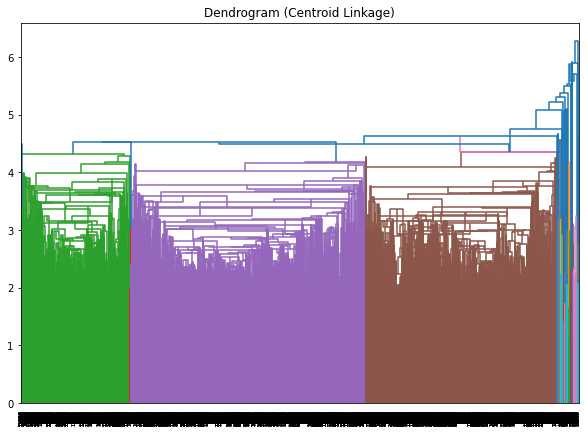

Metrics for Centroid Linkage with 4 clusters:
Contingency Matrix:
[[   3 5450]
 [  15 7142]]
Number of Clusters: 2
Samples per Cluster: [   18 12592]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5088358459514556
F-Measure: 0.8232597406324964



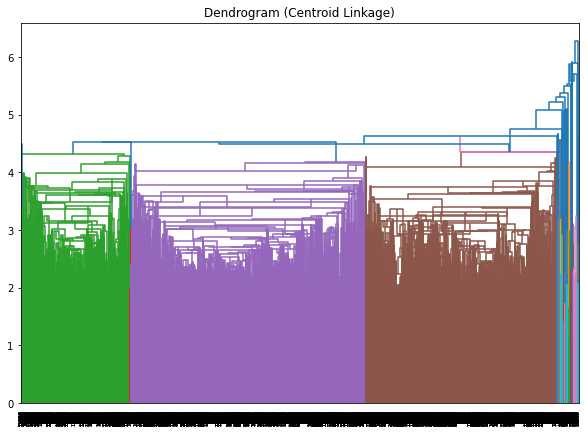

In [27]:
linkage_methods = ['single', 'complete', 'average', 'ward', 'centroid']
n_clusters_range = range(2, 5)  # Example: considering 2 to 4 clusters

for method in linkage_methods:
    # Perform hierarchical clustering
    linked = linkage(X, method=method)
    
    for n_clusters in n_clusters_range:
        # Obtain cluster labels
        y_pred = fcluster(linked, n_clusters, criterion='maxclust') 

        # Print contingency matrix and other metrics
        print(f"Metrics for {method.capitalize()} Linkage with {n_clusters} clusters:")
        print(f"Contingency Matrix:\n{metrics.cluster.contingency_matrix(y, y_pred)}")
        print(f"Number of Clusters: {np.unique(y_pred).size}")
        print(f"Samples per Cluster: {np.unique(y_pred, return_counts=True)[1]}")
        print(f"Purity Score: {purity_score(y, y_pred)}")
        print(f"Rand Index Score: {rand_index_score(y, y_pred)}")
        print(f"F-Measure: {f_measure(y, y_pred)}\n")

        # Plot the dendrogram
        plt.figure(figsize=(10, 7))
        dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
        plt.title(f"Dendrogram ({method.capitalize()} Linkage)")
        plt.show()
    

Métricas Externas
Pureza:

Avalia até que ponto cada cluster contém objetos de uma única classe.
Valores mais altos indicam melhor performance.
Índice Rand:

Mede a porcentagem de decisões corretas (isto é, pares de objetos no mesmo ou em diferentes clusters).
Valores mais altos indicam melhor performance.
F-Measure:

Combina precisão e recall para avaliar a qualidade do clustering.
Valores mais altos indicam melhor performance.

### K-medoids

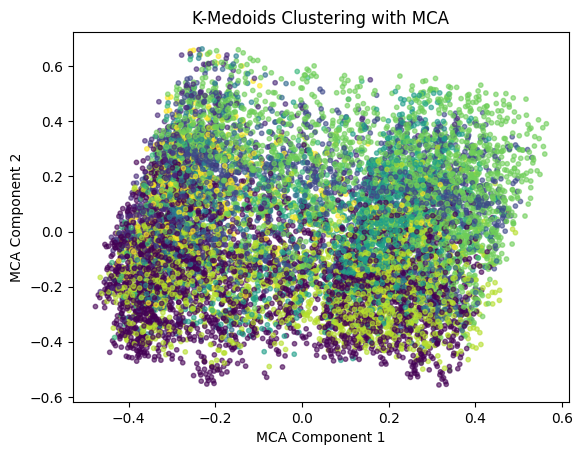

In [86]:
# K-Medoids clustering
kmedoids = KMedoids(n_clusters=10, random_state=0)
clusters = kmedoids.fit_predict(X)
                                
plt.scatter(X_mca[0], X_mca[1], c=clusters, cmap='viridis', alpha=0.6, s=10)
plt.title("K-Medoids Clustering with MCA")
plt.xlabel("MCA Component 1")
plt.ylabel("MCA Component 2")
plt.show()

In [87]:
df_test1 = df.copy()

In [88]:
df_test1['Cluster_Kmedoids'] = clusters

In [89]:
# Group by cluster label and then count the occurrences of each class in each cluster
class_distribution = df_test1.groupby('Cluster_Kmedoids')['Y'].value_counts()

print(class_distribution)

Cluster_Kmedoids  Y
0                 1    1527
                  0    1328
1                 1     433
                  0     312
2                 1     784
                  0     553
3                 1     283
                  0     138
4                 1     276
                  0     113
5                 1     463
                  0     426
6                 1     470
                  0     259
7                 1    1452
                  0    1057
8                 1    1188
                  0    1070
9                 1     281
                  0     197
Name: count, dtype: int64


In [14]:
# Range of k to evaluate
k_range = range(2, 10)  # Adjust according to your needs

# Store CH scores for each k
ch_scores = []

for k in k_range:
    # Apply K-Medoids
    kmedoids = KMedoids(n_clusters=k, random_state=0)
    clusters = kmedoids.fit_predict(X)
    
    # Calculate CH index
    ch_score = calinski_harabasz_score(X, clusters)
    ch_scores.append(ch_score)
    print(f"CH Score for k={k}: {ch_score}")

# Find the k with the highest CH score
best_k = k_range[ch_scores.index(max(ch_scores))]
print(f"Best number of clusters by CH index: {best_k}")

CH Score for k=2: 1810.1795221433588
CH Score for k=3: 993.4609532969721
CH Score for k=4: 681.2243821969652
CH Score for k=5: 525.252019306173
CH Score for k=6: 468.5927961372095
CH Score for k=7: 645.8646174028906
CH Score for k=8: 862.6776493125182
CH Score for k=9: 874.9098368676857
Best number of clusters by CH index: 2


### K-modes

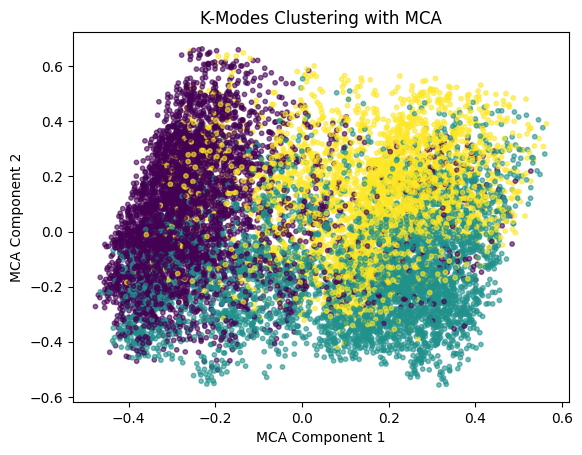

In [90]:
# K-Modes clustering
km = KModes(n_clusters=3, init='Huang', n_init=5, random_state=0)
clusters = km.fit_predict(X)

plt.scatter(X_mca[0], X_mca[1], c=clusters, cmap='viridis', alpha=0.6, s = 10)
plt.title("K-Modes Clustering with MCA")
plt.xlabel("MCA Component 1")
plt.ylabel("MCA Component 2")
plt.show()

In [92]:
df_test2 = df.copy()

df_test2['Cluster_Kmodes'] = clusters

# Group by cluster label and then count the occurrences of each class in each cluster
class_distribution = df_test2.groupby('Cluster_Kmodes')['Y'].value_counts()

print(class_distribution)

Cluster_Kmodes  Y
0               1    2795
                0    1562
1               1    2427
                0    2337
2               1    1935
                0    1554
Name: count, dtype: int64


In [12]:
from sklearn.metrics import calinski_harabasz_score

# Range of k to evaluate
k_range = range(2, 10)  # Adjust according to your needs

# Store CH scores for each k
ch_scores = []

for k in k_range:
    # Apply K-Modes
    km = KModes(n_clusters=k, init='Huang', random_state=42)
    clusters = km.fit_predict(X)
    
    # Calculate CH index
    ch_score = calinski_harabasz_score(X, clusters)
    ch_scores.append(ch_score)
    print(f"CH Score for k={k}: {ch_score}")

# Find the k with the highest CH score
best_k = k_range[ch_scores.index(max(ch_scores))]
print(f"Best number of clusters by CH index: {best_k}")

CH Score for k=2: 501.94758520922886
CH Score for k=3: 303.8719391630173
CH Score for k=4: 276.52770229937215
CH Score for k=5: 294.5535981928757
CH Score for k=6: 214.18987980628108
CH Score for k=7: 233.52608631937755
CH Score for k=8: 220.7497618945498
CH Score for k=9: 175.45447782011559
Best number of clusters by CH index: 2


### DBSCAN

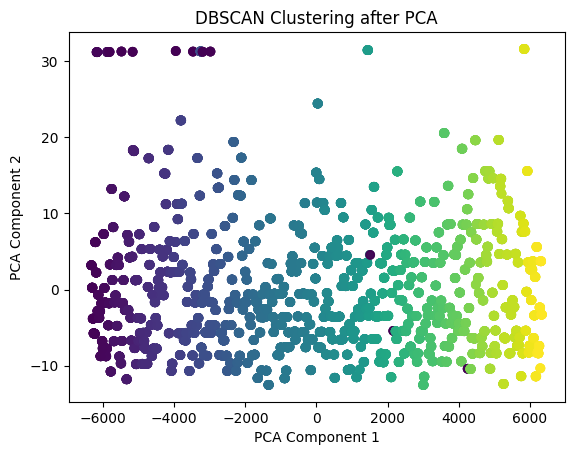

In [22]:
# DBSCAN clustering
dbscan = DBSCAN(eps=10, min_samples=10)
clusters = dbscan.fit_predict(X)

# Plotting
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title("DBSCAN Clustering after PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

### Spectral clustering

In [23]:
# Spectral Clustering
spectral = SpectralClustering(n_clusters=3, assign_labels='discretize', random_state=0)
clusters = spectral.fit_predict(X)

# Plotting
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title("Spectral Clustering after PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

/Users/davidsousa/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 